1. Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

2. Load the Data


In [2]:
plt.style.use('seaborn-v0_8')
train_df = pd.read_csv('hpp_data/train.csv')
test_df = pd.read_csv('hpp_data/test.csv')

# Combine train and test for consistent preprocessing
y = np.log1p(train_df["SalePrice"])
all_data = pd.concat([train_df.drop("SalePrice", axis=1), test_df], ignore_index=True)

2. Data Visualization: Before Preprocessing


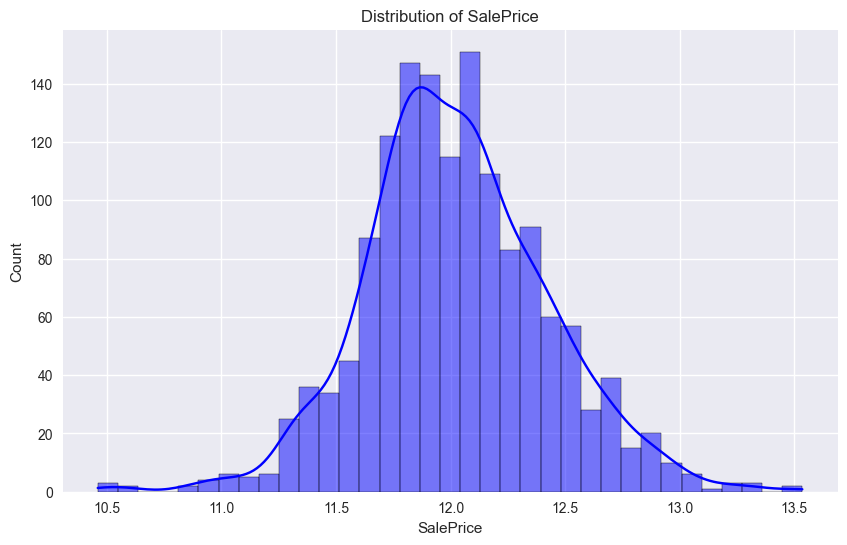

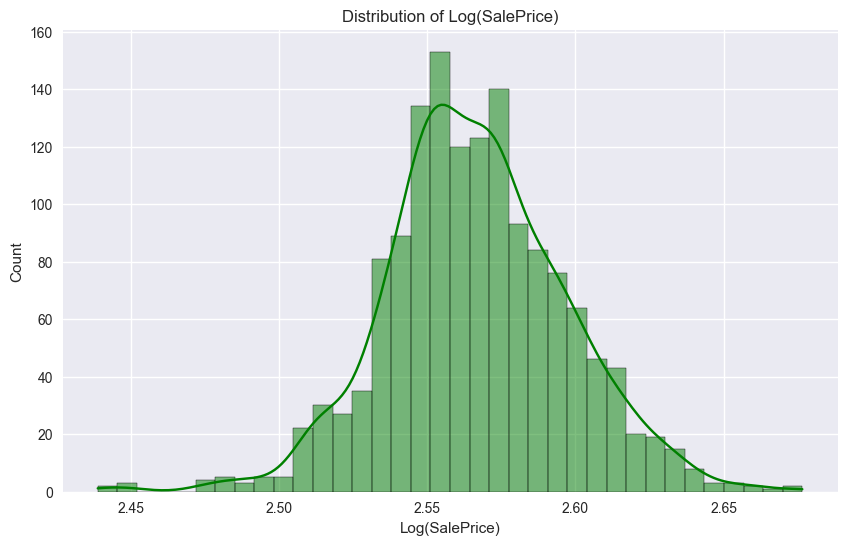

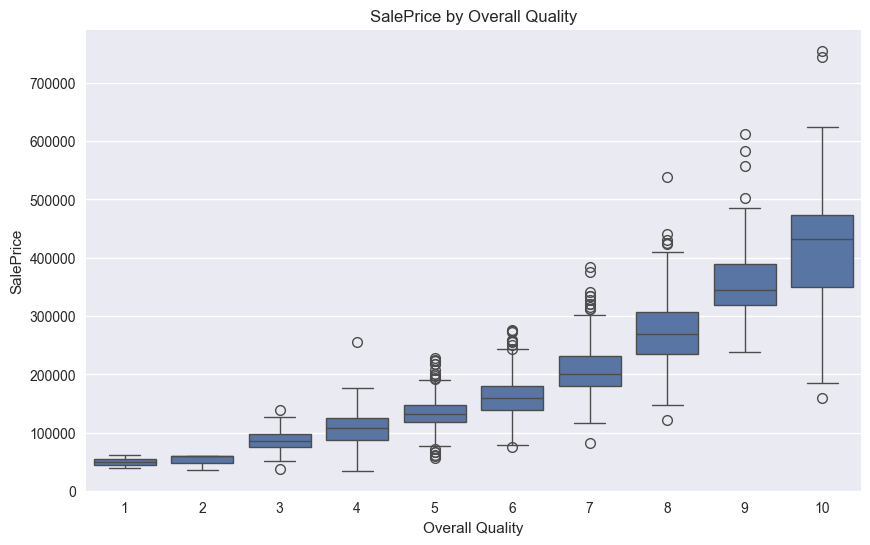

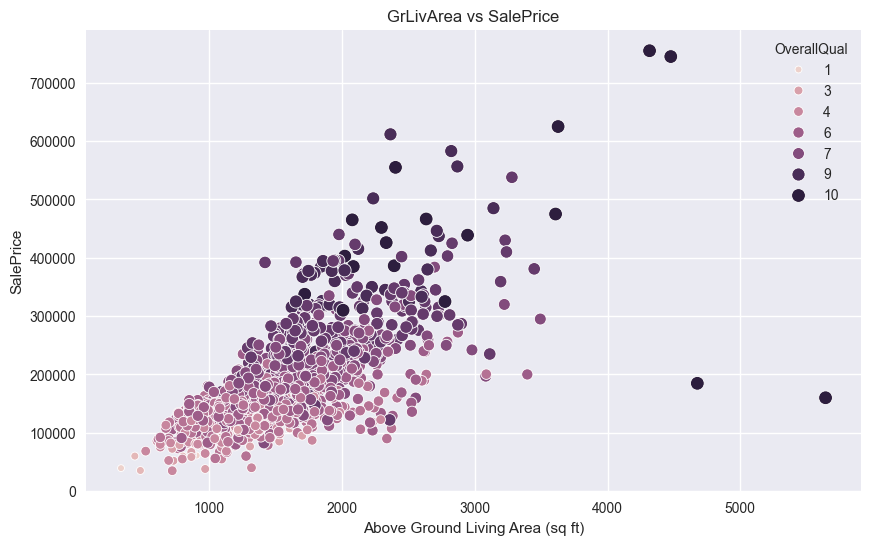

In [3]:
# Distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color='blue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.show()

# Log-transformed SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(y), kde=True, color='green')
plt.title('Distribution of Log(SalePrice)')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Count')
plt.show()

# Box plot of SalePrice by OverallQual
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('SalePrice by Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('SalePrice')
plt.show()

# Scatter plot of GrLivArea vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df, hue='OverallQual', size='OverallQual')
plt.title('GrLivArea vs SalePrice')
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('SalePrice')
plt.show()

3. Data Preprocessing


In [4]:
# Handle missing values without dropping columns
# Fill missing values
num_cols = all_data.select_dtypes(include=["int64", "float64"]).columns
cat_cols = all_data.select_dtypes(include=["object"]).columns

# Numeric: median
for col in num_cols:
    all_data[col].fillna(all_data[col].median(), inplace=True)

# Categorical: None or mode
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish',
             'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in none_cols:
    all_data[col].fillna('None', inplace=True)
for col in cat_cols:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

4. Feature Engineering


In [5]:
all_data["TotalSF"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"]
all_data["HouseAge"] = all_data["YrSold"] - all_data["YearBuilt"]
all_data["RemodAge"] = all_data["YrSold"] - all_data["YearRemodAdd"]
all_data["IsNew"] = (all_data["YearBuilt"] == all_data["YrSold"]).astype(int)
all_data["TotalBath"] = (all_data["FullBath"] + 0.5 * all_data["HalfBath"] +
                         all_data["BsmtFullBath"] + 0.5 * all_data["BsmtHalfBath"])
all_data["QualAreaInteraction"] = all_data["OverallQual"] * all_data["TotalSF"]

# Log-transform skewed features
skewed_feats = ['LotArea', 'TotalSF', 'GrLivArea', '1stFlrSF', '2ndFlrSF']
for feat in skewed_feats:
    all_data[feat] = np.log1p(all_data[feat])

# Polynomial features
poly_feats = ['TotalSF', 'GrLivArea', 'OverallQual', 'HouseAge']
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = pd.DataFrame(poly.fit_transform(all_data[poly_feats]),
                         columns=poly.get_feature_names_out(poly_feats), index=all_data.index)

# Avoid duplicate column names by removing originals that are re-added
all_data = all_data.drop(columns=poly_feats)
all_data = pd.concat([all_data, poly_data], axis=1)

all_data = all_data.loc[:, ~all_data.columns.duplicated()]


5. Exploratory Data Visualization

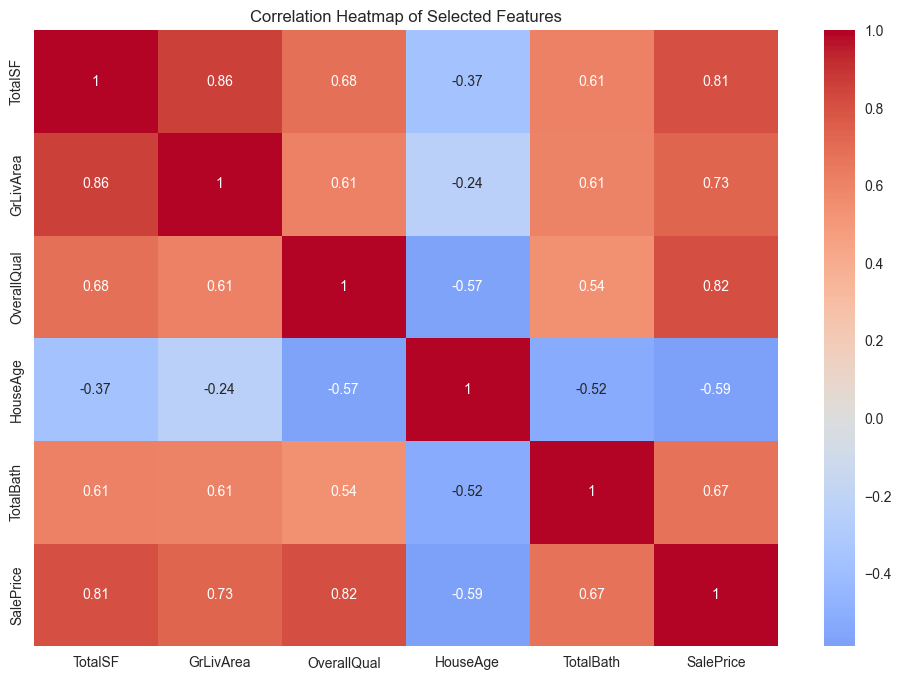

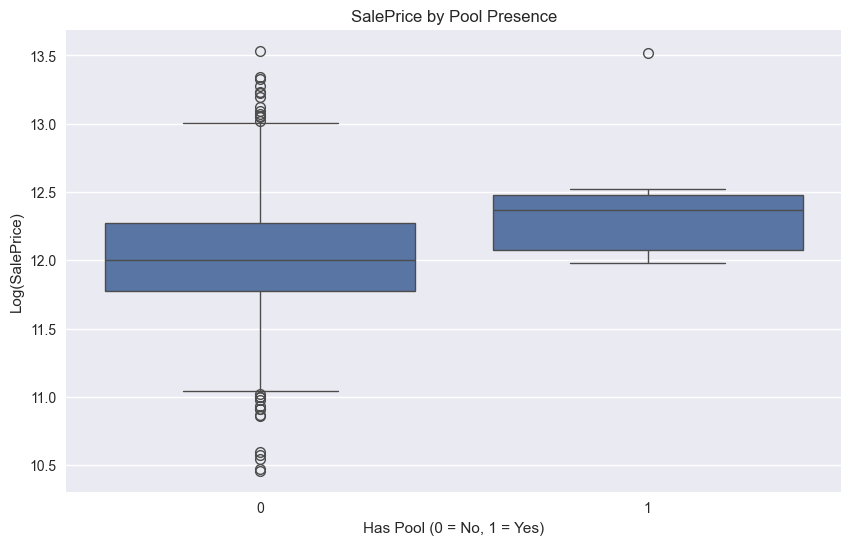

In [6]:
train_temp = all_data.iloc[:len(train_df)].copy()
train_temp['SalePrice'] = y  # Already log-transformed

# Define HasPool as a binary feature
train_temp['HasPool'] = (train_temp['PoolArea'] > 0).astype(int)

# Select features to visualize correlation
selected_features = ['TotalSF', 'GrLivArea', 'OverallQual', 'HouseAge', 'TotalBath', 'SalePrice']

# Compute correlation matrix
corr_matrix = train_temp[selected_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

# Plot SalePrice distribution by Pool presence
plt.figure(figsize=(10, 6))
sns.boxplot(x='HasPool', y='SalePrice', data=train_temp)
plt.title('SalePrice by Pool Presence')
plt.xlabel('Has Pool (0 = No, 1 = Yes)')
plt.ylabel('Log(SalePrice)')
plt.show()

6. Final Preprocessing Pipeline

In [7]:
X = all_data.iloc[:len(train_df), :]
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
])

X_train, X_valid, y_train_split, y_valid_split = train_test_split(X, y, test_size=0.2, random_state=42)

7. Train Multiple Models and Evaluate

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR()
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipeline.fit(X_train, y_train_split)
    preds = pipeline.predict(X_valid)
    
    results[name] = {
        "R2 Score": r2_score(y_valid_split, preds),
        "RMSE": np.sqrt(mean_squared_error(y_valid_split, preds)),
        "MAE": mean_absolute_error(y_valid_split, preds)
    }

# Create DataFrame and sort by RMSE
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")

# Display performance summary
print("📊 Model Performance Summary:")
display(results_df)

📊 Model Performance Summary:


,R2 Score,RMSE,MAE
Ridge Regression,0.913848,0.126795,0.085111
Gradient Boosting,0.896786,0.138783,0.091980
Random Forest,0.887489,0.144899,0.095350
Support Vector Regressor,0.885676,0.146062,0.096218
Linear Regression,0.833752,0.176135,0.091615
Lasso Regression,-0.005837,0.433244,0.337134


8. Hyperparameter Tuning

In [9]:
# GridSearchCV on Random Forest
param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}
grid_rf = GridSearchCV(Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
]), param_grid_rf, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train_split)
rf_preds = grid_rf.best_estimator_.predict(X_valid)

print("\n🔍 Best Random Forest Params:", grid_rf.best_params_)
print("R2 Score:", r2_score(y_valid_split, rf_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_valid_split, rf_preds)))
print("MAE:", mean_absolute_error(y_valid_split, rf_preds))

# RandomizedSearchCV on Gradient Boosting
param_dist_gb = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.8, 1.0],
    "model__min_samples_split": [2, 5, 10]
}
rand_gb = RandomizedSearchCV(Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
]), param_distributions=param_dist_gb, n_iter=20, cv=3,
   scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)

rand_gb.fit(X_train, y_train_split)
gb_preds = rand_gb.best_estimator_.predict(X_valid)

print("\n🔄 Best Gradient Boosting Params:", rand_gb.best_params_)
print("R2 Score:", r2_score(y_valid_split, gb_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_valid_split, gb_preds)))
print("MAE:", mean_absolute_error(y_valid_split, gb_preds))

Fitting 3 folds for each of 24 candidates, totalling 72 fits

🔍 Best Random Forest Params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
R2 Score: 0.8860191777113217
RMSE: 0.1458426341214425
MAE: 0.09600678767297523
Fitting 3 folds for each of 20 candidates, totalling 60 fits

🔄 Best Gradient Boosting Params: {'model__subsample': 1.0, 'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__max_depth': 5, 'model__learning_rate': 0.1}
R2 Score: 0.8960917255438166
RMSE: 0.1392495092230087
MAE: 0.08851377131907322


9. Final Model Comparison


In [10]:
final_results = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting"],
    "R2 Score": [r2_score(y_valid_split, rf_preds), r2_score(y_valid_split, gb_preds)],
    "RMSE": [np.sqrt(mean_squared_error(y_valid_split, rf_preds)),
             np.sqrt(mean_squared_error(y_valid_split, gb_preds))],
    "MAE": [mean_absolute_error(y_valid_split, rf_preds),
            mean_absolute_error(y_valid_split, gb_preds)]
})

print(" Final Comparison:")
print(final_results.sort_values("RMSE"))

 Final Comparison:
               Model  R2 Score      RMSE       MAE
1  Gradient Boosting  0.896092  0.139250  0.088514
0      Random Forest  0.886019  0.145843  0.096007
